In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk

In [2]:
## Initialize/Load Dubins

Xfull = np.load(os.getcwd() + "/Data/Glycolysis_data_tf5_8k_ctrl_smooth_healthy.npy")
# print(Xfull[2])
# print(Xfull.shape)
N_x, N_u, N_d = 10, 3, 10

t0, tf, th = 0., 5., 0.05
t_arr = np.arange(t0, tf + th, th)
n_T, N_T = 4, 101 # Number of sample trajectories, Length of ea. Trajectory

In [3]:
def svd_poly_map(m, n, err, model, train_ix, N_T, no_comp = False, EDMDc=False):

    for i in range(len(train_ix)):
        X = Xfull[:, :N_T, train_ix[i]]
        axs = []

        if not (no_comp):

            # Predict with DMDc linearization
            if not (EDMDc):
                Xhp = model.simulate(
                    X[:N_x, 0].T, X[N_x:N_x+N_u, :].T, n_steps=N_T-1)
                Xh = np.vstack((X[:N_x, 0].T, Xhp)).T

            else:
                Xh = simulate(model, X[:N_x, 0].T,
                              X[N_x:N_x+N_u, :].T, n_steps=N_T-1).T

        e_100 = np.linalg.norm(X[:N_x, :] - Xh, axis=0)
        e_sum_100 = np.linalg.norm(X[:N_x, :] - Xh, axis=0)

        e_50 = e_100[0:50]

        # prev = 0.0
        # for i in range (len(e_sum_50)):
        #     e_sum_50[i] += prev
        #     prev = e_sum_50[i]
        
        prev = 0.0
        for i in range(len(e_sum_100)):
            e_sum_100[i] += prev
            prev = e_sum_100[i]

        e_sum_50 = e_sum_100[0:50]


        # 2.5 s
        err[0,m,n] = np.mean(e_50)
        err[1,m,n] = np.mean(e_sum_50)

        err[2,m,n] = np.std(e_50)
        err[3,m,n] = np.std(e_sum_50)

        # 5.0 s
        err[4,m,n] = np.mean(e_100)
        err[5,m,n] = np.mean(e_sum_100)

        err[6,m,n] = np.std(e_100)
        err[7,m,n] = np.std(e_sum_100)




In [4]:
def plot_comparison_t_e(t_e_100, i):
    print("row", i+1)
    print("overall trajectory error at 2.5s: ", t_e_100[49])
    print("overall trajectory error at 5s: ", t_e_100[99])

In [5]:
def plot_comparison(model, train_ix, dim_to_plot=[0, 3, 4, 5], labels=["Glucose", "Py/Ac pool", "NADH", "ATP"], no_comp=False, n_T=5, N_T=100, EDMDc=False):

    n_col = len(dim_to_plot) + 1 # +1 for the error

    plt.tight_layout()
    plt.figure(figsize=(15, len(train_ix)*2))


    if no_comp:
        plt.suptitle("Sample Trajectories")
    elif EDMDc:
        plt.suptitle("EDMDc Linearizations of Sample Trajectories")
    else:
        plt.suptitle("DMDc Linearizations of Sample Trajectories")

    # plt.subplots_adjust(top=None)

    # fig, axs = plt.subplots(len(train_ix), n_col, figsize=(15, 15))
    for i in range(len(train_ix)):
        X = Xfull[:, :N_T, train_ix[i]]
        axs = []

        # Plot Nominal
        lab, col = "Nominal", plt.cm.tab10(0)

        for axi in range(n_col):

            ax = plt.subplot(len(train_ix), n_col, axi + i*n_col + 1)
            ax.set_xlabel("t")

            if axi < n_col - 1:
                ax.plot(t_arr[:N_T], X[dim_to_plot[axi], :],
                        alpha=0.8, label=lab, color=col)

                ax.set_ylabel(labels[axi])

                # graphing all
            else:
                ax.set_ylabel("Error")

            axs.append(ax)
        

        if not (no_comp):

            # Predict with DMDc linearization
            if not (EDMDc):
                Xhp = model.simulate(
                    X[:N_x, 0].T, X[N_x:N_x+N_u, :].T, n_steps=N_T-1)
                Xh = np.vstack((X[:N_x, 0].T, Xhp)).T

            else:
                Xh = simulate(model, X[:N_x, 0].T,
                              X[N_x:N_x+N_u, :].T, n_steps=N_T-1).T

            if i not in train_ix:
                for ax in axs:
                    for spine in ax.spines.values():
                        spine.set_edgecolor('pink')

            # Plot DMDc trajectory (adding to plots)
            lab, col = "DMDc", plt.cm.tab10(1)
            for axi in range(n_col):
                if axi < n_col - 1:
                    axs[axi].plot(t_arr[:N_T], Xh[dim_to_plot[axi], :],
                                  alpha=0.8, label=lab, color=col)
                else: # plotting error
                    axs[axi].plot(t_arr[:N_T], np.linalg.norm(
                        X[:N_x, :] - Xh, axis=0), alpha=0.8, label=lab, color=col)

        e_100 = np.linalg.norm(X[:N_x, :] - Xh, axis=0)
        t_e_100 = np.linalg.norm(X[:N_x, :] - Xh, axis=0)

        prev = 0.0
        for i in range(len(t_e_100)):
            t_e_100[i] += prev
            prev = t_e_100[i]
        # plot_comparison_t_e(t_e_100, i)
        # svd_poly_map(svd_d, poly_d, e_ind_100, e_sum_100)

    plt.show()


## Nominal Trajectories

In [6]:
# plot_comparison(None, [], no_comp=True)

## DMDc with one Trajectory

In [7]:
def fit_DMDc(train_ix, N_T=100, svd_rank=None):

    Xb = Xfull[:,:N_T,train_ix]

    ## Flatten Data (only matters if training with more than one traj)
    Xks, Xkps, Uks = [], [], []
    for i in range(len(train_ix)):
        Xks.append(Xb[:N_x, :-1, i]); Xkps.append(Xb[:N_x, 1:, i])
        Uks.append(Xb[N_x:N_x + N_u, :-1, i])
    Xk, Xkp, Uk = np.hstack(Xks).T, np.hstack(Xkps).T, np.hstack(Uks).T

    ## Fit with DMDc
    DMDc = pk.regression.DMDc(svd_rank=svd_rank)
    model = pk.koopman.Koopman(regressor=DMDc).fit(Xk, Uk, Xkp)

    return model

<Figure size 640x480 with 0 Axes>

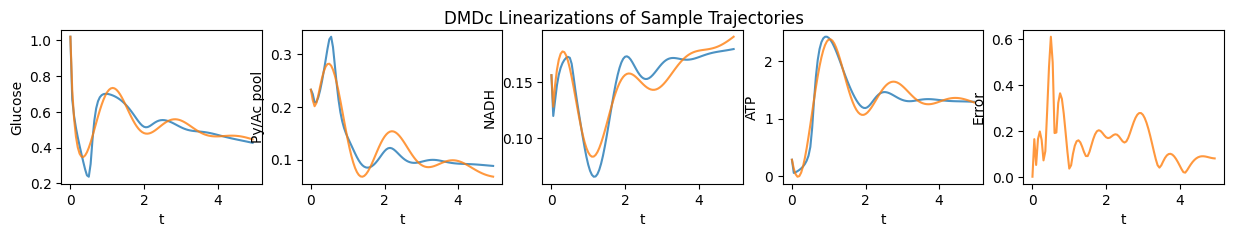

In [8]:
## Sample Trajectory 0

X = Xfull[:,:,0] # defining X ****
np.shape(X)
Xk, Uk = X[:N_x, :].T, X[N_x:N_x + N_u, :-1].T

## Fit with DMDc

DMDc = pk.regression.DMDc(svd_rank=5)
model = pk.koopman.Koopman(regressor=DMDc).fit(Xk, u=Uk)

## Compare True and DMDc

plot_comparison(model, [0])

In [9]:
# ## Sample Trajectory 1

# train_ix = [1]
# model = fit_DMDc(train_ix, svd_rank=4)
# plot_comparison(model, train_ix)

## DMDc with Multiple Trajectories

In [10]:
# ### DMDc with multiple trajectories

# train_ix = [0, 1]
# model = fit_DMDc(train_ix, svd_rank=4)
# plot_comparison(model, train_ix)

In [11]:
# ### DMDc with multiple trajectories

# train_ix = [0, 1, 2, 3]
# model = fit_DMDc(train_ix, svd_rank=None)
# plot_comparison(model, train_ix)


In [12]:
# train_ix = np.arange(0, 10)
# model = fit_DMDc(train_ix, svd_rank=None)
# plot_comparison(model, train_ix)

In [13]:
# train_ix = np.arange(0, 8000)
# model = fit_DMDc(train_ix, svd_rank=None)
# plot_comparison(model, train_ix)

# EDMD 

In [14]:
def fit_EDMDc(train_ix, observables, N_T=100, svd_rank=None, delay=0):
    Xb = Xfull[:, :N_T-delay, train_ix]

    ## Flatten Data (only matters if training with more than one traj)
    Xks, Xkps, Uks = [], [], []
    for i in range(len(train_ix)):
        Xks.append(Xb[:N_x, :-1, i]); Xkps.append(Xb[:N_x, 1:, i])
        Uks.append(Xb[N_x:N_x + N_u, :-1, i])
    Xk, Xkp, Uk = np.hstack(Xks).T, np.hstack(Xkps).T, np.hstack(Uks).T

    ## Fit with DMDc
    DMDc = pk.regression.DMDc(svd_rank=svd_rank)
    model = pk.Koopman(observables=observables, regressor=DMDc).fit(Xk, Uk, Xkp)

    # print(np.max(model.state_transition_matrix)) # model.control_matrix
    
    return model

## Polynomial: N_k = N_x + (N_x choose 2) + ... + (N_x choose degree)
Poly = pk.observables.Polynomial(
    degree=4,
    include_bias=True)

In [15]:
def simulate(model, X0, Uk, n_steps=100):
    
    G0 = model.observables.fit_transform(X0.reshape((1, Xk.shape[1])))
    A, B = model.state_transition_matrix, model.control_matrix

    Gh = np.zeros((n_steps+1, G0.shape[1]))
    Gh[0, :] = G0
    for i in range(1, n_steps+1):
        Gh[i, :] = (A @ Gh[i-1, :].T + B @ Uk[i-1, :].T).T

    Xh = model.observables.inverse(Gh)

    return Xh

<Figure size 640x480 with 0 Axes>

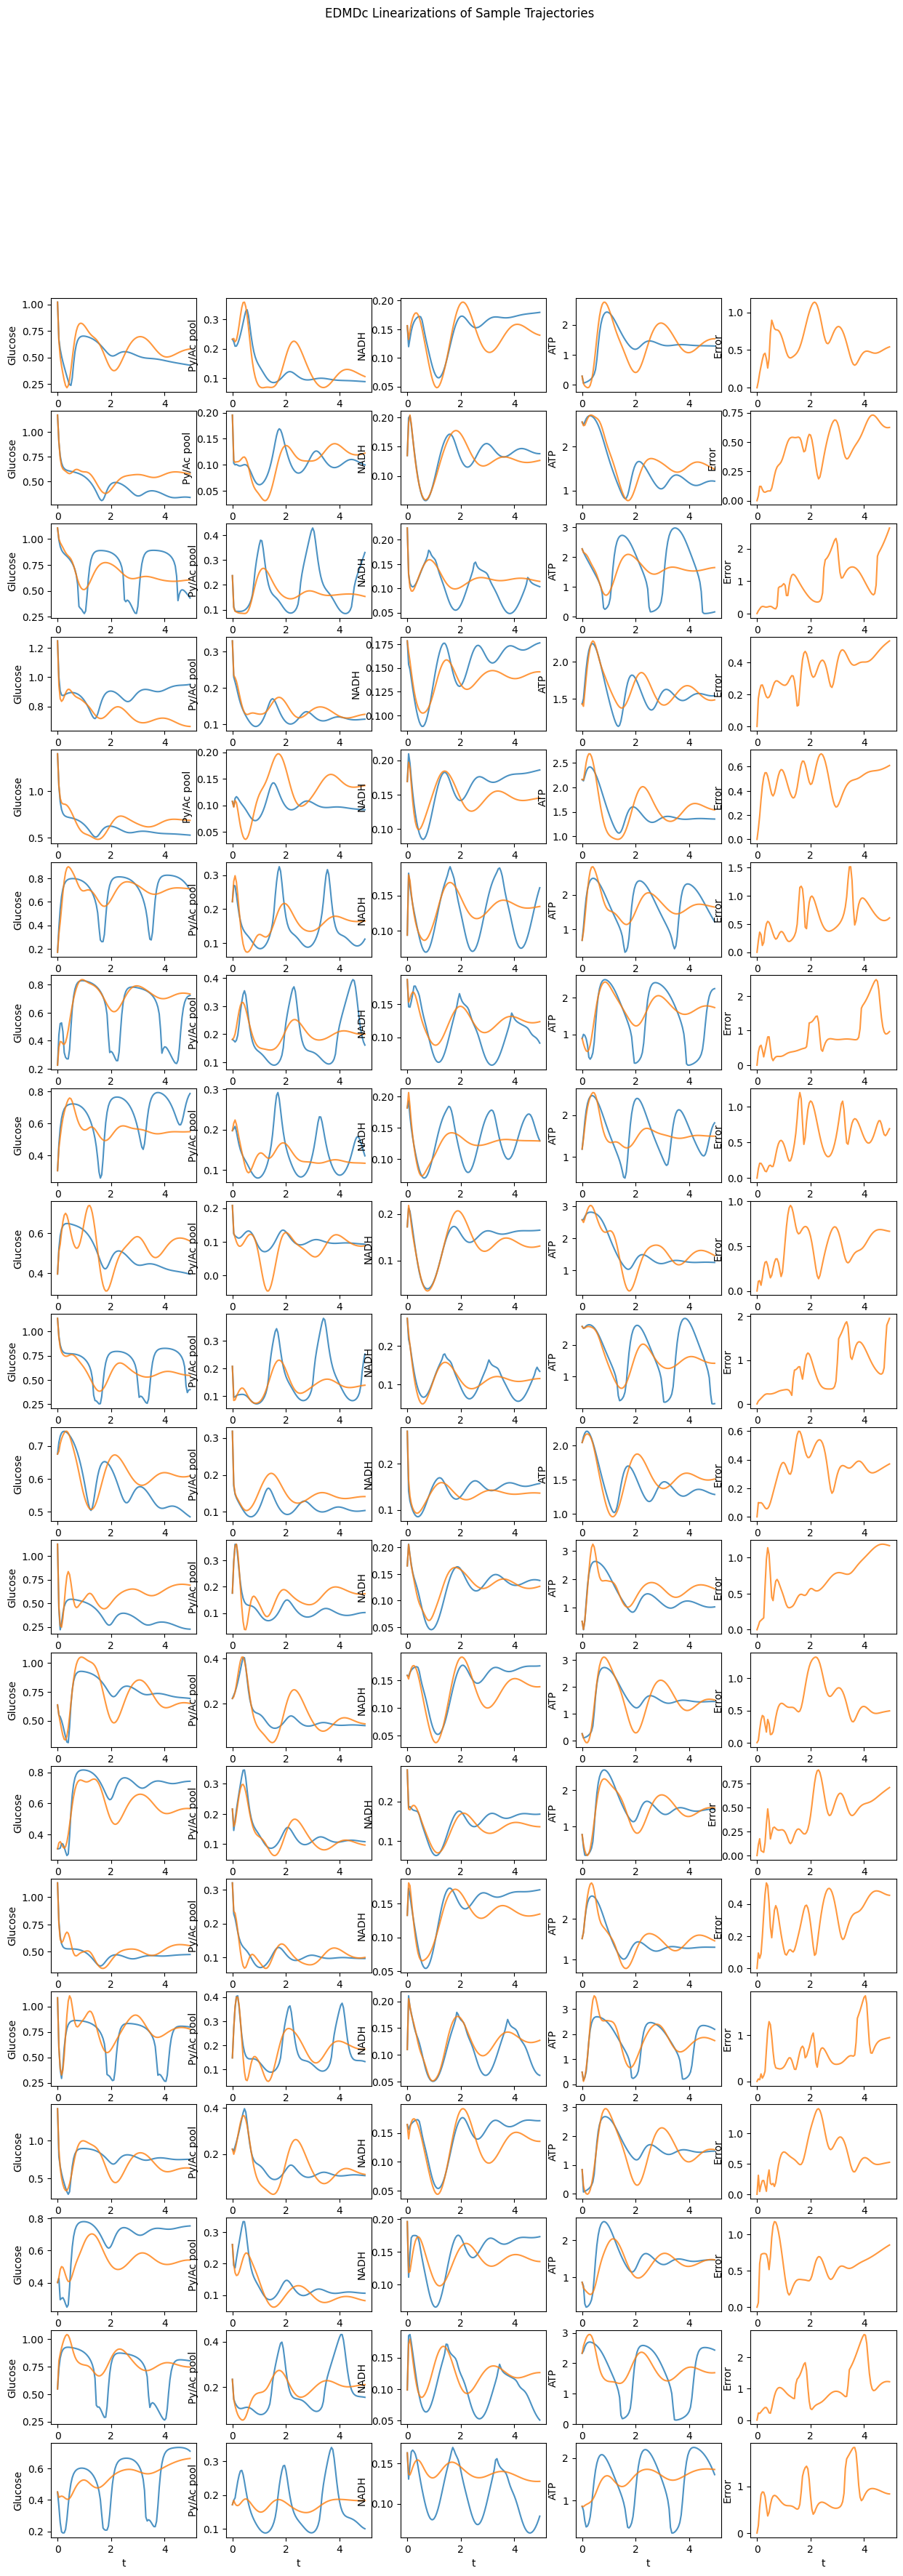

In [16]:
Poly = pk.observables.Polynomial(
    degree=4,
    include_bias=True)

train_ix = np.arange(20)
    
model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=50)
plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

In [17]:
# Poly = pk.observables.Polynomial(
#     degree=5,
#     include_bias=True)

# train_ix = [0, 1, 2, 3]
    
# model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=100)
# plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

In [18]:
# Poly = pk.observables.Polynomial(
#     degree=4,
#     include_bias=True)

# train_ix = np.arange(0, 8000)

# model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=100)
# plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

In [19]:
# Poly = pk.observables.Polynomial(
#     degree=4,
#     include_bias=True)

# train_ix = np.arange(0, 8000)

# model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=None)
# plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

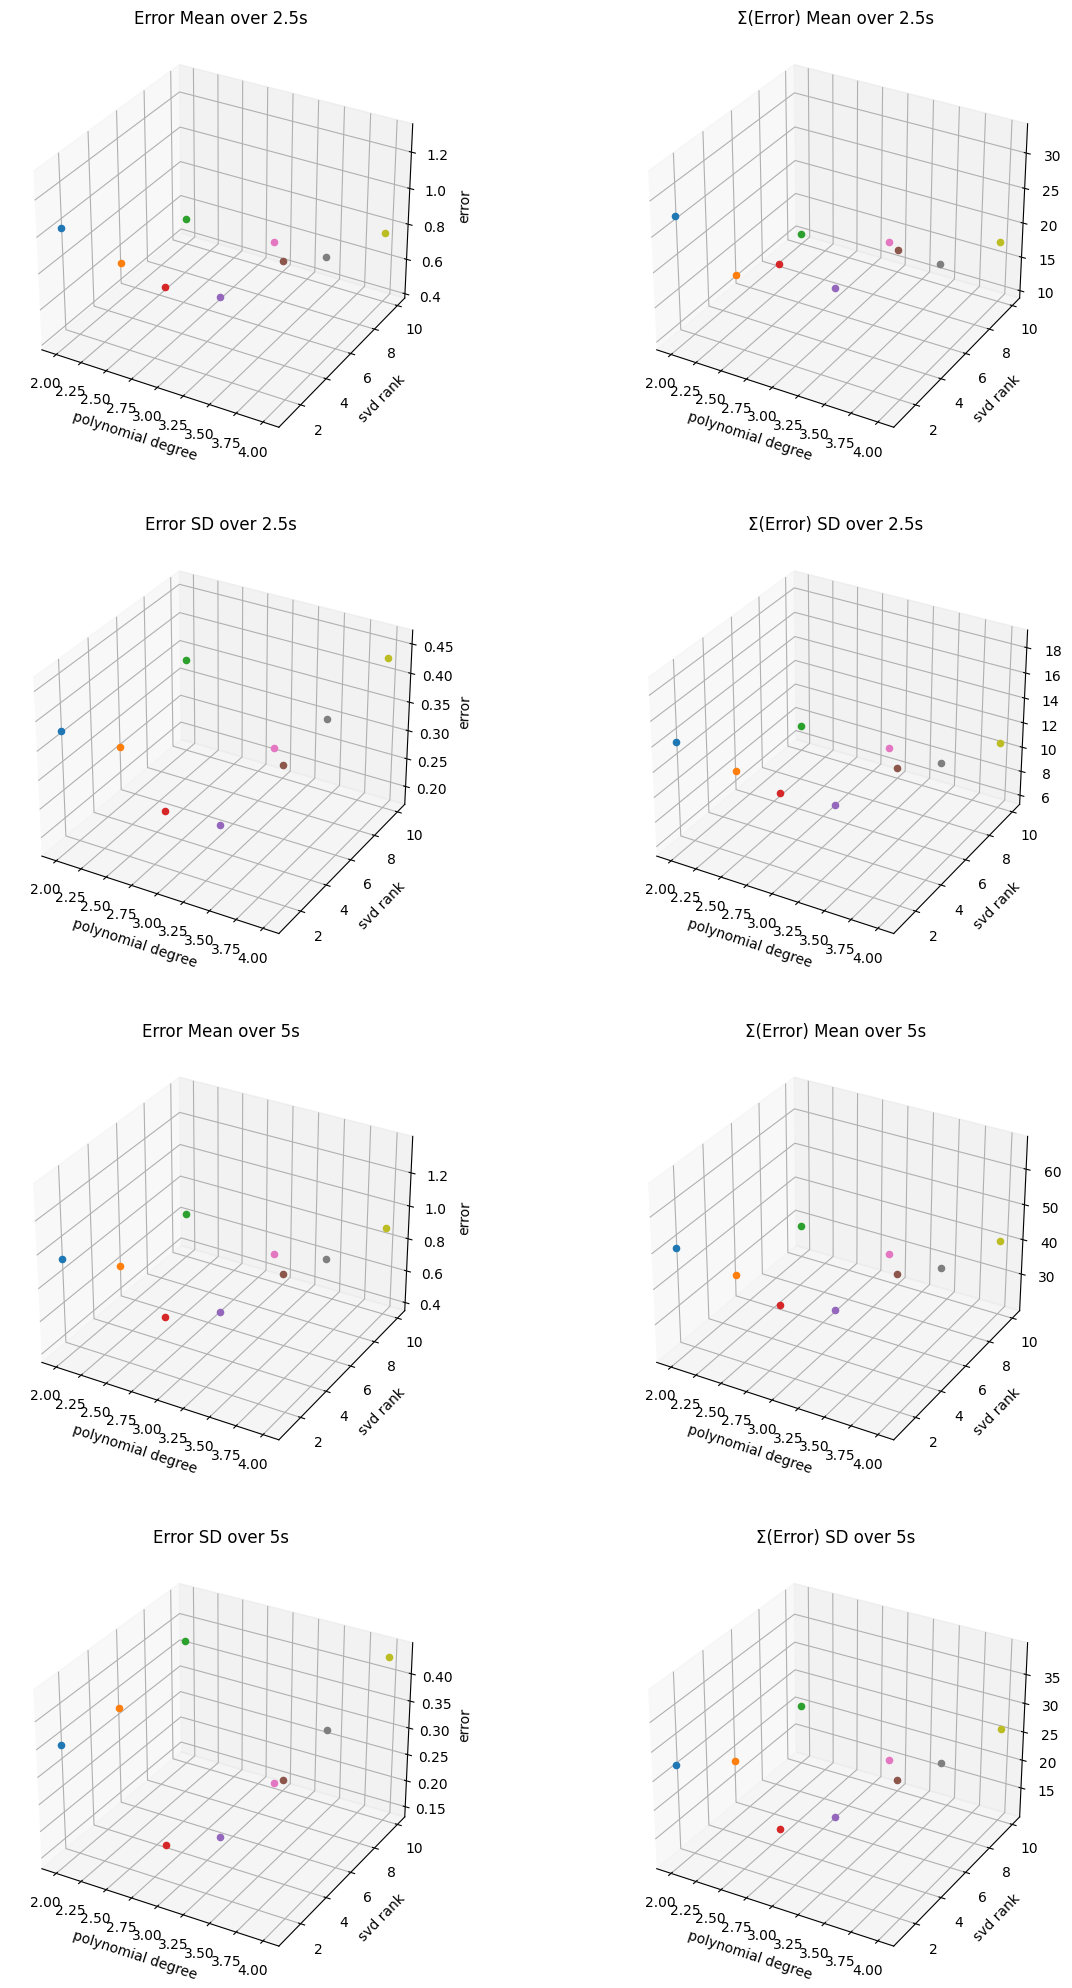

In [40]:
poly_d = [2,3,4]
svd_r = [1,5,10]
# only doing s=5 for now
err = np.zeros((8, len(poly_d), len(svd_r)))

err_m_ind = np.zeros((len(poly_d), len(svd_r)))
err_m_sum = np.zeros((len(poly_d), len(svd_r)))

err_sd_ind = np.zeros((len(poly_d), len(svd_r)))
err_sd_sum = np.zeros((len(poly_d), len(svd_r)))

for i, d in enumerate(poly_d): 
    Poly = pk.observables.Polynomial(
        degree=d, # changed degree and svd_rank
        include_bias=True)

    trial_ix = np.random.permutation(Xfull.shape[2])[:100]

    train_ix, test_ix = trial_ix[:50], trial_ix[50:] 
    
    for j, s in enumerate(svd_r):
        model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=s)
        # plot_comparison(model, test_ix, N_T = 100, EDMDc=True)
        
        svd_poly_map(i, j, err, model, train_ix, N_T=100, EDMDc=True)
        # dont plot one graph at once, build each one at the same time



titles = ["Error Mean over 2.5s", "Σ(Error) Mean over 2.5s", "Error SD over 2.5s", "Σ(Error) SD over 2.5s", "Error Mean over 5s", "Σ(Error) Mean over 5s", "Error SD over 5s", "Σ(Error) SD over 5s"]
fig, ax = plt.subplots()
fig.set_figheight(5*len(titles)/2)
fig.set_figwidth(12)

fig.tight_layout(w_pad=2)

for i in range(len(titles)):
    ax = plt.subplot(4, 2, i+1, projection='3d')
    ax.set_title(titles[i])
    ax.set_xlabel("polynomial degree")
    ax.set_ylabel("svd rank")
    ax.set_zlabel("error")

    for m in range(len(poly_d)):
        x = poly_d[m]

        for n in range(len(svd_r)):
            y = svd_r[n]
            z = err[i,m,n]
            ax.scatter(x,y,z, cmap='Greens')

    fig.savefig('plots.png')
    # plt.close()
    

In [ ]:
# Poly = pk.observables.Polynomial(
#     degree=5,
#     include_bias=True)

# train_ix = np.arange(0, 8000)

# model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=100)
# plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

### Delay (not working)

In [ ]:
# Delay = pk.observables.TimeDelay(
#     # delay=5, # dt
#     n_delays=5)
    
# Delay.fit_transform(Xk).shape

In [ ]:

# # train_ix = np.arange(0,4)
# train_ix = [0]

# model = fit_EDMDc(train_ix, Delay, N_T = 101, svd_rank=100, delay=0)
# # plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

In [ ]:
# Delay = pk.observables.TimeDelay(
#     # delay=5, # dt
#     n_delays=10)

# train_ix = np.arange(0, 8000)

# model = fit_EDMDc(train_ix, Poly, N_T = 100, svd_rank=100)
# plot_comparison(model, train_ix, N_T = 100, EDMDc=True)

## Scoring the Polynomial Fits

### Want to iterate through degree & svd_rank,
    - degree   : [2, 3, 4, 5, 6]
    - svd_rank : [10, 30, 100, 300, 1000] ? ? ? 

### while training on 90% of each if the following trajectory sets (numbers indicate index of full data set)
    {[auto]:[0, 2000], 
     [ctrl]:[2000, 10000], 
     [auto + ctrl sets][:]}, 
     
and tracking the score on the training set and the remaining 10% of each set. 

### Score should be quantified with the normalized two-norm
    - of trajectory error @ t_ix = 50 (2.5 s)
    - of trajectory error summed from t_ix = 1 to t_ix = 50
    - of trajectory error @ t_ix = 100 (5 s)
    - of trajectory error summed from t_ix = 1 to t_ix = 100